# Predicting Poverty 
Este trabajo tiene el objetivo de predecir la pobreza a nivel de _hogares_ utilizando data a nivel hogares e individuos. Se combinan ambos niveles de desagregación para obtener una mejor predicción.

El estudio tiene base en una muestra de Bogotá en el 2018 llamada _Medición de Pobreza Monetaria y Desigualdad Report_ realizada por la Gran Encuesta Integrada de Hogares (GEIH).”

## Importación y _merge_ de bases: Train y Test
A continuación, se realiza el _merge_ entre individuos y hogares para la muestra _train_ y la muestra _test_

In [4]:
import pandas as pd

# Define la ruta de la carpeta donde están los archivos
ruta_carpeta = r"C:\Users\dalig\OneDrive\Documents\Maestría\Machine Learning\PS2\Stores"

# Cargar los archivos CSV en dataframes
test_hogares = pd.read_csv(f"{ruta_carpeta}\\test_hogares.csv")
test_personas = pd.read_csv(f"{ruta_carpeta}\\test_personas.csv")
train_hogares = pd.read_csv(f"{ruta_carpeta}\\train_hogares.csv")
train_personas = pd.read_csv(f"{ruta_carpeta}\\train_personas.csv")

# Asegúrate de que la columna 'id' esté en minúsculas y en formato string
for df in [test_hogares, test_personas, train_hogares, train_personas]:
    if 'id' in df.columns:
        df['id'] = df['id'].str.lower().astype(str)

# Realizar el merge one-to-many entre test_hogares y test_personas
test_merged = pd.merge(test_hogares, test_personas, on='id', how='left', suffixes=('_hogar', '_persona'))

# Realizar el merge one-to-many entre train_hogares y train_personas
train_merged = pd.merge(train_hogares, train_personas, on='id', how='left', suffixes=('_hogar', '_persona'))


# Imprimir la cantidad de observaciones y columnas en test_merged
print(f"test_merged: {test_merged.shape[0]} observaciones, {test_merged.shape[1]} columnas")

# Imprimir la cantidad de observaciones y columnas en train_merged
print(f"train_merged: {train_merged.shape[0]} observaciones, {train_merged.shape[1]} columnas")


test_merged: 219644 observaciones, 78 columnas
train_merged: 543109 observaciones, 157 columnas


## Limpieza de las bases de datos
A continuación, se formula la muestra de interés. Se eliminan _outliers_ en las edades.

In [6]:
# Definir los DataFrames y la columna
dataframes = [test_merged, train_merged]
names = ['test_merged', 'train_merged']

# Bucle para filtrar ambos DataFrames
for df, name in zip(dataframes, names):
    # Filtrar el DataFrame para que P6040 sea menor o igual a 100
    antes = df.shape[0]  # Número de filas antes de filtrar
    df = df[df['P6040'] <= 100]
    despues = df.shape[0]  # Número de filas después de filtrar
    
    # Mostrar el resultado
    print(f"Se eliminaron {antes - despues} filas en {name} dataframe")
    
    # Actualizar el DataFrame original
    globals()[name] = df

# Filtrar valores de 'Ingtot' fuera de un rango razonable
train_merged = train_merged[train_merged['Ingtot'] > 0]  # Elimina los valores negativos o cero


Se eliminaron 15 filas en test_merged dataframe
Se eliminaron 56 filas en train_merged dataframe


## Variables de interés 
En esta sección se crean y renombran variables que serán pertinentes para un análisis posterior.

In [8]:
import numpy as np
# Renombres
dataframes = [test_merged, train_merged]
names = ['test_merged', 'train_merged']
renombrar = {'P6040': 'edad'}

# Dummies
for df, name in zip(dataframes, names):
    df = df.rename(columns=renombrar)

    df['sexo'] = np.where(df['P6020'] == 1, 1, np.where(df['P6210'].isna(), np.nan, 0)) #Vale 1 para hombres
    df['preescolar'] = np.where(df['P6210'] == 2, 1, np.where(df['P6210'].isna(), np.nan, 0))
    df['primaria'] = np.where(df['P6210'] == 3, 1, np.where(df['P6210'].isna(), np.nan, 0))
    df['secundaria'] = np.where(df['P6210'] == 4, 1, np.where(df['P6210'].isna(), np.nan, 0))
    df['media'] = np.where(df['P6210'] == 5, 1, np.where(df['P6210'].isna(), np.nan, 0))
    df['superior'] = np.where(df['P6210'] == 6, 1, np.where(df['P6210'].isna(), np.nan, 0))
    df['subsidio_alimentacion'] = np.where(df['P6585s1'] == 1, 1, np.where(df['P6585s1'].isna(), np.nan, 0))
    df['subsidio_transporte'] = np.where(df['P6585s2'] == 1, 1, np.where(df['P6585s1'].isna(), np.nan, 0))
    df['subsidio_familiar'] = np.where(df['P6585s3'] == 1, 1, np.where(df['P6585s1'].isna(), np.nan, 0))
    df['subsidio_educativo'] = np.where(df['P6585s3'] == 1, 1, np.where(df['P6585s1'].isna(), np.nan, 0))

    globals()[name] = df

## Descripción de las muestras
A continuación, se detallan las **estadísticas descriptivas** de los datos de ambas muestras. Se muestra la composición de ambas muestras teniendo en cuenta 

In [10]:
# Lista de variables de interés
variables_interes = ['sexo', 'edad', 'preescolar', 'primaria', 'secundaria', 'media', 'superior']

# DataFrames a iterar
dataframes = [test_merged, train_merged]
names = ['test_merged', 'train_merged']

for df, name in zip(dataframes, names):
    df_descriptive_stats = df[variables_interes].describe(include='all')
    print(f"Estadísticas descriptivas para {name}:")
    print(df_descriptive_stats.T) 
    print("\n" + "-"*50 + "\n")


Estadísticas descriptivas para test_merged:
               count       mean        std  min   25%   50%   75%    max
sexo        215148.0   0.482714   0.499702  0.0   0.0   0.0   1.0    1.0
edad        219629.0  33.499165  21.678515  0.0  16.0  30.0  50.0  100.0
preescolar  210460.0   0.028979   0.167749  0.0   0.0   0.0   0.0    1.0
primaria    210460.0   0.261869   0.439653  0.0   0.0   0.0   1.0    1.0
secundaria  210460.0   0.182077   0.385909  0.0   0.0   0.0   0.0    1.0
media       210460.0   0.228514   0.419876  0.0   0.0   0.0   0.0    1.0
superior    210460.0   0.241010   0.427697  0.0   0.0   0.0   0.0    1.0

--------------------------------------------------

Estadísticas descriptivas para train_merged:
               count       mean        std   min   25%   50%   75%    max
sexo        311097.0   0.504746   0.499978   0.0   0.0   1.0   1.0    1.0
edad        311097.0  43.556897  17.402615  10.0  29.0  41.0  56.0  100.0
preescolar  311097.0   0.000061   0.007815   0.0   0

Se observa que le 48% de la muestra es hombre y, en promedio, el 24% de la población tiene como máximo nivel educativo alcanzado el nivel superior.

Para brindar más detalle sobre los resultados y las variables creadas, se presenta un gráfico de barras que muestra consistencias entre las de la muestra _test_ y las características de la muestra _train_.

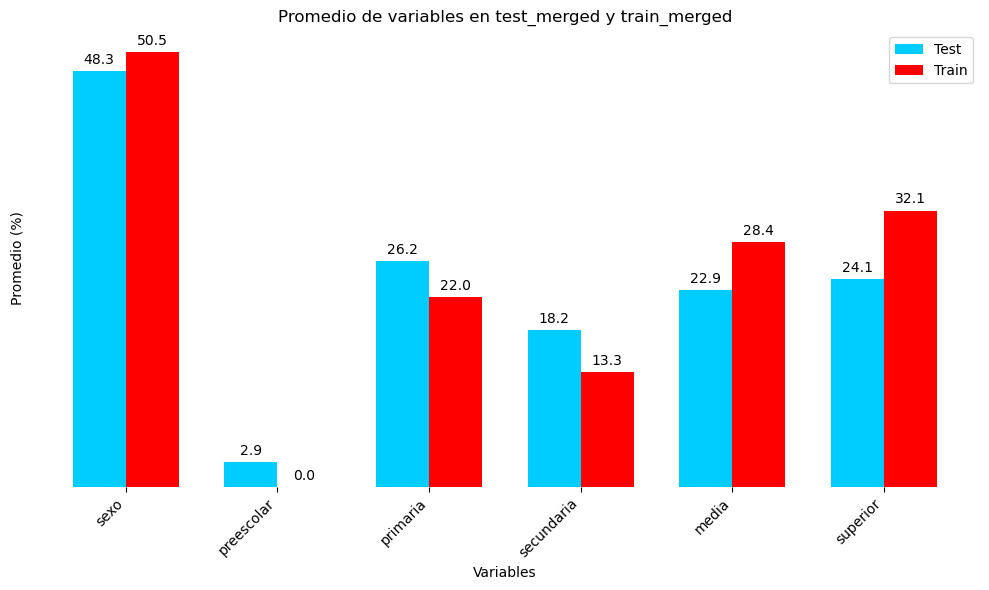

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

ruta_destino = r'..\Views\grafico1.png'
# Lista de variables de interés sin incluir 'edad'
variables_grafico = ['sexo', 'preescolar', 'primaria', 'secundaria', 'media', 'superior']

# Calcular las medias multiplicadas por 100
means_test = test_merged[variables_grafico].mean() * 100
means_train = train_merged[variables_grafico].mean() * 100

# Crear el gráfico
x = np.arange(len(variables_grafico))  # Índices para las variables
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))

# Barras para test_merged
bars_test = ax.bar(x - width/2, means_test, width, label='Test', color='#00CDFF')

# Barras para train_merged
bars_train = ax.bar(x + width/2, means_train, width, label='Train', color='#FF0000')

# Personalizar el gráfico
ax.set_xlabel('Variables')
ax.set_ylabel('Promedio (%)')
ax.set_title('Promedio de variables en test_merged y train_merged')
ax.set_xticks(x)
ax.set_xticklabels(variables_grafico, rotation=45, ha='right')
ax.legend()

# Eliminar la caja de los ejes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Eliminar los números del eje y
ax.yaxis.set_ticks([])

# Añadir líneas de cuadrícula horizontales (opcional)
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Mostrar valores en las barras
for bars in [bars_test, bars_train]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',  # Mostrar la media con 1 decimal
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Ajuste de la posición del texto
                    textcoords="offset points",
                    ha='center', va='bottom')

# Mostrar el gráfico
plt.tight_layout()
plt.grid(False)

# Exportación de gráficos
plt.savefig(ruta_destino, format='png')
plt.show()

In [14]:
# Lista de variables de interés
variables_interes = ['sexo', 'edad', 'preescolar', 'primaria', 'secundaria', 'media', 'superior']

# Bucle para eliminar filas con valores faltantes en las variables de interés
for var in variables_interes:
    train_merged = train_merged.dropna(subset=[var])
    test_merged = test_merged.dropna(subset=[var])

# Ahora, train_merged y test_merged no tendrán NaN en las columnas seleccionadas

## Modelos y resultados

Esta sección presenta distintas especificaciones de modelos utilizados para las tareas predictivas. El objetivo es predecir el nivel de ingreso de un hogar utilizando variables que la literatura económica relaciona con el ingreso, como por ejemplo la educación (Mincer, 1974). 

Un hogar se clasifica como pobre de la siguiente manera:
$$
\text{Poor} = I(\text{Inc} < P_l)
$$

donde $\textit{I}$ es una función indicadora que toma valor uno si el ingreso familiar se encuentra por debajo del ingreso familiar. 

Para ello se pueden estableceder dos formas alternativas de predecir la pobreza: 
1. Como un problema de clasificación, donde se predice ceros (no pobres) y unos (pobres)
2. Costruyendo ingresos predichos y utilizando la línea de pobreza para obtener la clasificación

En el presente trabajo nos concetramos en la segunda alternativa. Se le recomienda al lector leer con detenimiento las instrucciones en los comentarios en cada paso de las distintas estimaciones.



In [17]:
# Convertir columnas a numéricas, si corresponde
test_merged['sexo'] = pd.to_numeric(test_merged['sexo'], errors='coerce')
test_merged['edad'] = pd.to_numeric(test_merged['edad'], errors='coerce')


## 1. Regresión lineal (I)

In [19]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 1. Entrenar el modelo de regresión lineal en train_merged
X_train = train_merged[['sexo', 'edad', 'preescolar', 'primaria', 'secundaria', 'media', 'superior']]
y_train = train_merged['Ingtot']

# Eliminar filas con valores nulos en los regresores y la variable dependiente
train_cleaned = train_merged.dropna(subset=['sexo', 'edad', 'preescolar', 'primaria', 'secundaria', 'media', 'superior', 'Ingtot'])

# Extraer datos limpios
X_train_cleaned = train_cleaned[['sexo', 'edad', 'preescolar', 'primaria', 'secundaria', 'media', 'superior']]
y_train_cleaned = train_cleaned['Ingtot']

# Crear y ajustar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train_cleaned, y_train_cleaned)

# Predecir el ingreso en train_merged y guardarlo
train_cleaned['Ingreso_predicho'] = model.predict(X_train_cleaned)
train_merged.loc[train_cleaned.index, 'Ingreso_predicho'] = train_cleaned['Ingreso_predicho']

# 2. Usar el modelo para predecir el `Ingreso_predicho` en test_merged
X_test = test_merged[['sexo', 'edad', 'preescolar', 'primaria', 'secundaria', 'media', 'superior']]

# Limpiar los datos de test_merged (eliminando valores nulos)
test_cleaned = test_merged.dropna(subset=['sexo', 'edad', 'preescolar', 'primaria', 'secundaria', 'media', 'superior'])
X_test_cleaned = test_cleaned[['sexo', 'edad', 'preescolar', 'primaria', 'secundaria', 'media', 'superior']]

# Predecir el `Ingreso_predicho` en test_merged
test_cleaned['Ingreso_predicho'] = model.predict(X_test_cleaned)
test_merged.loc[test_cleaned.index, 'Ingreso_predicho'] = test_cleaned['Ingreso_predicho']

# 3. Realizar la regresión en test_merged donde `Ingreso_predicho` es la variable explicativa
# Ahora realizamos la regresión donde `Ingreso_predicho` será la variable explicativa
# y `Lp` será la variable dependiente
X_test_reg = test_cleaned[['Ingreso_predicho']]
y_test_reg = test_cleaned['Lp']

# Crear el modelo de regresión para `test_merged`
model_test = LinearRegression()
model_test.fit(X_test_reg, y_test_reg)

# Predecir `Lp` usando el modelo ajustado en test_merged
test_cleaned['Lp_predicho'] = model_test.predict(X_test_reg)
test_merged.loc[test_cleaned.index, 'Lp_predicho'] = test_cleaned['Lp_predicho']

# 4. Crear la dummy de pobreza
test_merged['Pobreza'] = (test_merged['Ingreso_predicho'] < test_merged['Lp']).astype(int)

# 5. Evaluar el modelo en train_merged (si se desea)
mse_train = mean_squared_error(train_cleaned['Ingtot'], train_cleaned['Ingreso_predicho'])
r2_train = r2_score(train_cleaned['Ingtot'], train_cleaned['Ingreso_predicho'])

# Mostrar las métricas de train_merged
print(f"\nMean Squared Error (MSE) en train_merged: {mse_train}")
print(f"R² en train_merged: {r2_train}")

# 6. Exportar el CSV con la columna 'id' y la dummy 'Pobreza' a la ruta deseada
ruta_destino = r'..\Views\modelo1.csv'  # Ruta de destino

# Exportar el archivo CSV
output = test_merged[['id', 'Pobreza']].dropna()  # Eliminar filas donde 'id' o 'Pobreza' sean nulos
output.to_csv(ruta_destino, index=False)

print(f"\nExportación completada. Archivo generado en: {ruta_destino}")



Mean Squared Error (MSE) en train_merged: 1937202293638.456
R² en train_merged: 0.17107498293989243

Exportación completada. Archivo generado en: ..\Views\modelo1.csv


El modelo tiene estimaciones muy pobres. Realizaremos una segunda especificación de la regresión lineal.

## 2. Regresión lineal (II)

In [22]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 1. Entrenar el modelo de regresión lineal en train_merged
X_train = train_merged[['sexo', 'edad', 'preescolar', 'primaria', 'secundaria', 'media', 'superior',
                       'subsidio_alimentacion', 'subsidio_transporte', 'subsidio_familiar', 'subsidio_educativo']]
y_train = train_merged['Ingtot']

# Eliminar filas con valores nulos en los regresores y la variable dependiente
train_cleaned = train_merged.dropna(subset=['sexo', 'edad', 'preescolar', 'primaria', 'secundaria', 'media', 'superior',
                                            'subsidio_alimentacion', 'subsidio_transporte', 'subsidio_familiar', 'subsidio_educativo',
                                            'Ingtot'])

# Extraer datos limpios
X_train_cleaned = train_cleaned[['sexo', 'edad', 'preescolar', 'primaria', 'secundaria', 'media', 'superior',
                                'subsidio_alimentacion', 'subsidio_transporte', 'subsidio_familiar', 'subsidio_educativo']]
y_train_cleaned = train_cleaned['Ingtot']

# Crear y ajustar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train_cleaned, y_train_cleaned)

# Predecir el ingreso en train_merged y guardarlo
train_cleaned['Ingreso_predicho'] = model.predict(X_train_cleaned)
train_merged.loc[train_cleaned.index, 'Ingreso_predicho'] = train_cleaned['Ingreso_predicho']

# 2. Usar el modelo para predecir el `Ingreso_predicho` en test_merged
X_test = test_merged[['sexo', 'edad', 'preescolar', 'primaria', 'secundaria', 'media', 'superior']]

# Limpiar los datos de test_merged (eliminando valores nulos)
test_cleaned = test_merged.dropna(subset=['sexo', 'edad', 'preescolar', 'primaria', 'secundaria', 'media', 'superior',
                                         'subsidio_alimentacion', 'subsidio_transporte', 'subsidio_familiar', 'subsidio_educativo'])
X_test_cleaned = test_cleaned[['sexo', 'edad', 'preescolar', 'primaria', 'secundaria', 'media', 'superior',
                              'subsidio_alimentacion', 'subsidio_transporte', 'subsidio_familiar', 'subsidio_educativo']]

# Predecir el `Ingreso_predicho` en test_merged
test_cleaned['Ingreso_predicho'] = model.predict(X_test_cleaned)
test_merged.loc[test_cleaned.index, 'Ingreso_predicho'] = test_cleaned['Ingreso_predicho']

# 3. Realizar la regresión en test_merged donde `Ingreso_predicho` es la variable explicativa
# Ahora realizamos la regresión donde `Ingreso_predicho` será la variable explicativa
# y `Lp` será la variable dependiente
X_test_reg = test_cleaned[['Ingreso_predicho']]
y_test_reg = test_cleaned['Lp']

# Crear el modelo de regresión para `test_merged`
model_test = LinearRegression()
model_test.fit(X_test_reg, y_test_reg)

# Predecir `Lp` usando el modelo ajustado en test_merged
test_cleaned['Lp_predicho'] = model_test.predict(X_test_reg)
test_merged.loc[test_cleaned.index, 'Lp_predicho'] = test_cleaned['Lp_predicho']

# 4. Crear la dummy de pobreza
test_merged['Pobreza'] = (test_merged['Ingreso_predicho'] < test_merged['Lp']).astype(int)

# 5. Evaluar el modelo en train_merged (si se desea)
mse_train = mean_squared_error(train_cleaned['Ingtot'], train_cleaned['Ingreso_predicho'])
r2_train = r2_score(train_cleaned['Ingtot'], train_cleaned['Ingreso_predicho'])

# Mostrar las métricas de train_merged
print(f"\nMean Squared Error (MSE) en train_merged: {mse_train}")
print(f"R² en train_merged: {r2_train}")

# 6. Exportar el CSV con la columna 'id' y la dummy 'Pobreza' a la ruta deseada
ruta_destino = r'..\Views\modelo2.csv'  # Ruta de destino

# Exportar el archivo CSV
output = test_merged[['id', 'Pobreza']].dropna()  # Eliminar filas donde 'id' o 'Pobreza' sean nulos
output.to_csv(ruta_destino, index=False)

print(f"\nExportación completada. Archivo generado en: {ruta_destino}")


C:\Users\dalig\AppData\Local\Temp\ipykernel_6180\3656493092.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cleaned['Ingreso_predicho'] = model.predict(X_train_cleaned)
C:\Users\dalig\AppData\Local\Temp\ipykernel_6180\3656493092.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_cleaned['Ingreso_predicho'] = model.predict(X_test_cleaned)
C:\Users\dalig\AppData\Local\Temp\ipykernel_6180\3656493092.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr


Mean Squared Error (MSE) en train_merged: 2171261287005.7332
R² en train_merged: 0.21751608501223563

Exportación completada. Archivo generado en: ..\Views\modelo2.csv


## 3. Estimación Logit

$$
p_i =  \frac{e^{X_i\beta}}{1+e^{X_i\beta}}
$$

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# 1. Definir los regresores y variable explicativa en train_merged
X_train_merged = train_merged[['sexo', 'preescolar', 'primaria', 'secundaria', 'media', 'superior']]
y_train_merged = (train_merged['Ingtot'] > train_merged['Lp']).astype(int)  # Variable binaria: 1 si Ingtot > Lp, 0 si no

# 2. Crear y entrenar el modelo logit (regresión logística)
model_logit = LogisticRegression(max_iter=10000, class_weight='balanced')
model_logit.fit(X_train_merged, y_train_merged)

# 3. Predecir en train_merged (esto nos da las probabilidades de pobreza en el conjunto de entrenamiento)
train_merged['Pobreza_pred_train'] = model_logit.predict(X_train_merged)

# 4. Calcular la exactitud (accuracy) del modelo en el conjunto de entrenamiento
accuracy_train = accuracy_score(y_train_merged, train_merged['Pobreza_pred_train'])
print(f"Exactitud en el conjunto de entrenamiento: {accuracy_train}")

# 5. Reporte de clasificación para el conjunto de entrenamiento
print(f"Reporte de clasificación para el conjunto de entrenamiento:\n{classification_report(y_train_merged, train_merged['Pobreza_pred_train'])}")

# 6. Estimar las probabilidades de pobreza en test_merged usando el modelo entrenado
X_test_merged = test_merged[['sexo', 'preescolar', 'primaria', 'secundaria', 'media', 'superior']]
test_merged['Pobreza_pred'] = model_logit.predict(X_test_merged)

# 7. Crear la columna 'Pobreza' en test_merged
test_merged['Pobreza'] = (test_merged['Pobreza_pred'] == 1).astype(int)  # Si la predicción es 1, la variable 'Pobreza' será 1

# 8. Exportar los resultados a un archivo CSV con id y la variable 'Pobreza'
resultado = test_merged[['id', 'Pobreza']]
resultado.to_csv(r'..\Views\modelo3.csv', index=False)

print("Exportación completada. Archivo generado en: ..\Views\modelo3.csv")

<>:34: SyntaxWarning: invalid escape sequence '\V'
<>:34: SyntaxWarning: invalid escape sequence '\V'
C:\Users\dalig\AppData\Local\Temp\ipykernel_6180\852890471.py:34: SyntaxWarning: invalid escape sequence '\V'
  print("Exportación completada. Archivo generado en: ..\Views\modelo3.csv")


Exactitud en el conjunto de entrenamiento: 0.7068084873849635
Reporte de clasificación para el conjunto de entrenamiento:
              precision    recall  f1-score   support

           0       0.32      0.63      0.43     54131
           1       0.90      0.72      0.80    256966

    accuracy                           0.71    311097
   macro avg       0.61      0.68      0.62    311097
weighted avg       0.80      0.71      0.74    311097

Exportación completada. Archivo generado en: ..\Views\modelo3.csv


## 4. CARTs (I)

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# 1. Definir los regresores y variable explicativa en train_merged
X_train_merged = train_merged[['sexo', 'preescolar', 'primaria', 'secundaria', 'media', 'superior']]
y_train_merged = (train_merged['Ingtot'] > train_merged['Lp']).astype(int)  # Variable binaria: 1 si Ingtot > Lp, 0 si no

# 2. Crear y entrenar el modelo de árbol de decisión (CART)
model_cart = DecisionTreeClassifier(class_weight='balanced', max_depth=5)  # Ajusta max_depth según lo necesario
model_cart.fit(X_train_merged, y_train_merged)

# 3. Predecir en train_merged (esto nos da las predicciones de pobreza en el conjunto de entrenamiento)
train_merged['Pobreza_pred_train'] = model_cart.predict(X_train_merged)

# 4. Calcular la exactitud (accuracy) del modelo en el conjunto de entrenamiento
accuracy_train = accuracy_score(y_train_merged, train_merged['Pobreza_pred_train'])
print(f"Exactitud en el conjunto de entrenamiento: {accuracy_train}")

# 5. Reporte de clasificación para el conjunto de entrenamiento
print(f"Reporte de clasificación para el conjunto de entrenamiento:\n{classification_report(y_train_merged, train_merged['Pobreza_pred_train'])}")

# 6. Estimar las probabilidades de pobreza en test_merged usando el modelo entrenado
X_test_merged = test_merged[['sexo', 'preescolar', 'primaria', 'secundaria', 'media', 'superior']]
test_merged['Pobreza_pred'] = model_cart.predict(X_test_merged)

# 7. Crear la columna 'Pobreza' en test_merged
test_merged['Pobreza'] = (test_merged['Pobreza_pred'] == 1).astype(int)  # Si la predicción es 1, la variable 'Pobreza' será 1

# 8. Exportar los resultados a un archivo CSV con id y la variable 'Pobreza'
resultado = test_merged[['id', 'Pobreza']]
resultado.to_csv(r'..\Views\modelo4.csv', index=False)

print("Exportación completada. Archivo generado en: ..\Views\modelo4.csv")

<>:34: SyntaxWarning: invalid escape sequence '\V'
<>:34: SyntaxWarning: invalid escape sequence '\V'
C:\Users\dalig\AppData\Local\Temp\ipykernel_6180\2774528179.py:34: SyntaxWarning: invalid escape sequence '\V'
  print("Exportación completada. Archivo generado en: ..\Views\modelo4.csv")


Exactitud en el conjunto de entrenamiento: 0.7068084873849635
Reporte de clasificación para el conjunto de entrenamiento:
              precision    recall  f1-score   support

           0       0.32      0.63      0.43     54131
           1       0.90      0.72      0.80    256966

    accuracy                           0.71    311097
   macro avg       0.61      0.68      0.62    311097
weighted avg       0.80      0.71      0.74    311097

Exportación completada. Archivo generado en: ..\Views\modelo4.csv


## 5. CARTs (II)

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# 1. Definir los regresores y variable explicativa en train_merged
X_train_merged = train_merged[['sexo', 'subsidio_alimentacion', 'subsidio_transporte', 'subsidio_familiar', 'subsidio_educativo']]
y_train_merged = (train_merged['Ingtot'] > train_merged['Lp']).astype(int)  # Variable binaria: 1 si Ingtot > Lp, 0 si no

# 2. Crear y entrenar el modelo de árbol de decisión (CART)
model_cart = DecisionTreeClassifier(class_weight='balanced', max_depth=5)  # Ajusta max_depth según lo necesario
model_cart.fit(X_train_merged, y_train_merged)

# 3. Predecir en train_merged (esto nos da las predicciones de pobreza en el conjunto de entrenamiento)
train_merged['Pobreza_pred_train'] = model_cart.predict(X_train_merged)

# 4. Calcular la exactitud (accuracy) del modelo en el conjunto de entrenamiento
accuracy_train = accuracy_score(y_train_merged, train_merged['Pobreza_pred_train'])
print(f"Exactitud en el conjunto de entrenamiento: {accuracy_train}")

# 5. Reporte de clasificación para el conjunto de entrenamiento
print(f"Reporte de clasificación para el conjunto de entrenamiento:\n{classification_report(y_train_merged, train_merged['Pobreza_pred_train'])}")

# 6. Estimar las probabilidades de pobreza en test_merged usando el modelo entrenado
X_test_merged = test_merged[['sexo', 'subsidio_alimentacion', 'subsidio_transporte', 'subsidio_familiar', 'subsidio_educativo']]
test_merged['Pobreza_pred'] = model_cart.predict(X_test_merged)

# 7. Crear la columna 'Pobreza' en test_merged
test_merged['Pobreza'] = (test_merged['Pobreza_pred'] == 1).astype(int)  # Si la predicción es 1, la variable 'Pobreza' será 1

# 8. Exportar los resultados a un archivo CSV con id y la variable 'Pobreza'
resultado = test_merged[['id', 'Pobreza']]
resultado.to_csv(r'..\Views\modelo5.csv', index=False)

print("Exportación completada. Archivo generado en: ..\Views\modelo5.csv")

<>:34: SyntaxWarning: invalid escape sequence '\V'
<>:34: SyntaxWarning: invalid escape sequence '\V'
C:\Users\dalig\AppData\Local\Temp\ipykernel_6180\1473462001.py:34: SyntaxWarning: invalid escape sequence '\V'
  print("Exportación completada. Archivo generado en: ..\Views\modelo5.csv")


Exactitud en el conjunto de entrenamiento: 0.7430287016589681
Reporte de clasificación para el conjunto de entrenamiento:
              precision    recall  f1-score   support

           0       0.37      0.67      0.48     54131
           1       0.92      0.76      0.83    256966

    accuracy                           0.74    311097
   macro avg       0.64      0.72      0.65    311097
weighted avg       0.82      0.74      0.77    311097

Exportación completada. Archivo generado en: ..\Views\modelo5.csv


## 6. CARTs (III)

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# 1. Definir los regresores y variable explicativa en train_merged
X_train_merged = train_merged[['sexo', 'preescolar', 'primaria', 'secundaria', 'media', 'superior',
                               'subsidio_alimentacion', 'subsidio_transporte', 'subsidio_familiar', 'subsidio_educativo']]
y_train_merged = (train_merged['Ingtot'] > train_merged['Lp']).astype(int)  # Variable binaria: 1 si Ingtot > Lp, 0 si no

# 2. Crear y entrenar el modelo de árbol de decisión (CART)
model_cart = DecisionTreeClassifier(class_weight='balanced', max_depth=5)  # Ajusta max_depth según lo necesario
model_cart.fit(X_train_merged, y_train_merged)

# 3. Predecir en train_merged (esto nos da las predicciones de pobreza en el conjunto de entrenamiento)
train_merged['Pobreza_pred_train'] = model_cart.predict(X_train_merged)

# 4. Calcular la exactitud (accuracy) del modelo en el conjunto de entrenamiento
accuracy_train = accuracy_score(y_train_merged, train_merged['Pobreza_pred_train'])
print(f"Exactitud en el conjunto de entrenamiento: {accuracy_train}")

# 5. Reporte de clasificación para el conjunto de entrenamiento
print(f"Reporte de clasificación para el conjunto de entrenamiento:\n{classification_report(y_train_merged, train_merged['Pobreza_pred_train'])}")

# 6. Estimar las probabilidades de pobreza en test_merged usando el modelo entrenado
X_test_merged = test_merged[['sexo', 'preescolar', 'primaria', 'secundaria', 'media', 'superior',
                             'subsidio_alimentacion', 'subsidio_transporte', 'subsidio_familiar', 'subsidio_educativo']]
test_merged['Pobreza_pred'] = model_cart.predict(X_test_merged)

# 7. Crear la columna 'Pobreza' en test_merged
test_merged['Pobreza'] = (test_merged['Pobreza_pred'] == 1).astype(int)  # Si la predicción es 1, la variable 'Pobreza' será 1

# 8. Exportar los resultados a un archivo CSV con id y la variable 'Pobreza'
resultado = test_merged[['id', 'Pobreza']]
resultado.to_csv(r'..\Views\modelo6.csv', index=False)

print("Exportación completada. Archivo generado en: ..\Views\modelo6.csv")

<>:36: SyntaxWarning: invalid escape sequence '\V'
<>:36: SyntaxWarning: invalid escape sequence '\V'
C:\Users\dalig\AppData\Local\Temp\ipykernel_6180\497156253.py:36: SyntaxWarning: invalid escape sequence '\V'
  print("Exportación completada. Archivo generado en: ..\Views\modelo6.csv")


Exactitud en el conjunto de entrenamiento: 0.6476500898433607
Reporte de clasificación para el conjunto de entrenamiento:
              precision    recall  f1-score   support

           0       0.31      0.85      0.46     54131
           1       0.95      0.60      0.74    256966

    accuracy                           0.65    311097
   macro avg       0.63      0.73      0.60    311097
weighted avg       0.84      0.65      0.69    311097

Exportación completada. Archivo generado en: ..\Views\modelo6.csv


La inclusión de los subsidios adiciona un ruido que desmejora levemente la estimación.

## 7. Random Forest (I)

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# 1. Definir los regresores y variable explicativa en train_merged
X_train_merged = train_merged[['sexo', 'preescolar', 'primaria', 'secundaria', 'media', 'superior']]
y_train_merged = (train_merged['Ingtot'] > train_merged['Lp']).astype(int)  # Variable binaria: 1 si Ingtot > Lp, 0 si no

# 2. Crear y entrenar el modelo de Random Forest
model_rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model_rf.fit(X_train_merged, y_train_merged)

# 3. Predecir en train_merged (esto nos da las predicciones de pobreza en el conjunto de entrenamiento)
train_merged['Pobreza_pred_train'] = model_rf.predict(X_train_merged)

# 4. Calcular la exactitud (accuracy) del modelo en el conjunto de entrenamiento
accuracy_train = accuracy_score(y_train_merged, train_merged['Pobreza_pred_train'])
print(f"Exactitud en el conjunto de entrenamiento: {accuracy_train}")

# 5. Reporte de clasificación para el conjunto de entrenamiento
print(f"Reporte de clasificación para el conjunto de entrenamiento:\n{classification_report(y_train_merged, train_merged['Pobreza_pred_train'])}")

# 6. Estimar las probabilidades de pobreza en test_merged usando el modelo entrenado
X_test_merged = test_merged[['sexo', 'preescolar', 'primaria', 'secundaria', 'media', 'superior']]
test_merged['Pobreza_pred'] = model_rf.predict(X_test_merged)

# 7. Crear la columna 'Pobreza' en test_merged
test_merged['Pobreza'] = (test_merged['Pobreza_pred'] == 1).astype(int)  # Si la predicción es 1, la variable 'Pobreza' será 1

# 8. Exportar los resultados a un archivo CSV con id y la variable 'Pobreza'
resultado = test_merged[['id', 'Pobreza']]
resultado.to_csv(r'..\Views\modelo7.csv', index=False)

print("Exportación completada. Archivo generado en: ..\Views\modelo7.csv")


<>:34: SyntaxWarning: invalid escape sequence '\V'
<>:34: SyntaxWarning: invalid escape sequence '\V'
C:\Users\dalig\AppData\Local\Temp\ipykernel_6180\571295781.py:34: SyntaxWarning: invalid escape sequence '\V'
  print("Exportación completada. Archivo generado en: ..\Views\modelo7.csv")


Exactitud en el conjunto de entrenamiento: 0.7068084873849635
Reporte de clasificación para el conjunto de entrenamiento:
              precision    recall  f1-score   support

           0       0.32      0.63      0.43     54131
           1       0.90      0.72      0.80    256966

    accuracy                           0.71    311097
   macro avg       0.61      0.68      0.62    311097
weighted avg       0.80      0.71      0.74    311097

Exportación completada. Archivo generado en: ..\Views\modelo7.csv


## Random Forest (II)

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# 1. Definir los regresores y variable explicativa en train_merged
X_train_merged = train_merged[['sexo', 'preescolar', 'primaria', 'secundaria', 'media', 'superior',
                              'subsidio_alimentacion', 'subsidio_transporte', 'subsidio_familiar', 'subsidio_educativo']]
y_train_merged = (train_merged['Ingtot'] > train_merged['Lp']).astype(int)  # Variable binaria: 1 si Ingtot > Lp, 0 si no

# 2. Crear y entrenar el modelo de Random Forest
model_rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model_rf.fit(X_train_merged, y_train_merged)

# 3. Predecir en train_merged (esto nos da las predicciones de pobreza en el conjunto de entrenamiento)
train_merged['Pobreza_pred_train'] = model_rf.predict(X_train_merged)

# 4. Calcular la exactitud (accuracy) del modelo en el conjunto de entrenamiento
accuracy_train = accuracy_score(y_train_merged, train_merged['Pobreza_pred_train'])
print(f"Exactitud en el conjunto de entrenamiento: {accuracy_train}")

# 5. Reporte de clasificación para el conjunto de entrenamiento
print(f"Reporte de clasificación para el conjunto de entrenamiento:\n{classification_report(y_train_merged, train_merged['Pobreza_pred_train'])}")

# 6. Estimar las probabilidades de pobreza en test_merged usando el modelo entrenado
X_test_merged = test_merged[['sexo', 'preescolar', 'primaria', 'secundaria', 'media', 'superior',
                            'subsidio_alimentacion', 'subsidio_transporte', 'subsidio_familiar', 'subsidio_educativo']]
test_merged['Pobreza_pred'] = model_rf.predict(X_test_merged)

# 7. Crear la columna 'Pobreza' en test_merged
test_merged['Pobreza'] = (test_merged['Pobreza_pred'] == 1).astype(int)  # Si la predicción es 1, la variable 'Pobreza' será 1

# 8. Exportar los resultados a un archivo CSV con id y la variable 'Pobreza'
resultado = test_merged[['id', 'Pobreza']]
resultado.to_csv(r'..\Views\modelo8.csv', index=False)

print("Exportación completada. Archivo generado en: ..\Views\modelo8.csv")


<>:36: SyntaxWarning: invalid escape sequence '\V'
<>:36: SyntaxWarning: invalid escape sequence '\V'
C:\Users\dalig\AppData\Local\Temp\ipykernel_6180\3350347845.py:36: SyntaxWarning: invalid escape sequence '\V'
  print("Exportación completada. Archivo generado en: ..\Views\modelo8.csv")


Exactitud en el conjunto de entrenamiento: 0.6476500898433607
Reporte de clasificación para el conjunto de entrenamiento:
              precision    recall  f1-score   support

           0       0.31      0.85      0.46     54131
           1       0.95      0.60      0.74    256966

    accuracy                           0.65    311097
   macro avg       0.63      0.73      0.60    311097
weighted avg       0.84      0.65      0.69    311097

Exportación completada. Archivo generado en: ..\Views\modelo8.csv
